In [37]:
##SKLEARN
#Import scikit-learn metrics module for accuracy calculation}
from sklearn import metrics
#TSNE exploration
from sklearn.manifold import TSNE
#PCA
from sklearn.decomposition import PCA
##ML models and feature selection
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

##Matplotlib
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
from mpl_toolkits import mplot3d
import seaborn as sns
#OpenCV
import cv2

#Utility functions for dataset management
import ast
import copy
import pandas as pd
import os
import numpy as np

#Load in the dataset
colnames=['Instance', 'No_In_Sequence', 'Class', 'Joint_1','Joint_2','Joint_3','Joint_4','Joint_5','Joint_6','Joint_7',
          'Joint_8','Joint_9','Joint_10','Joint_11','Joint_12','Joint_13','Joint_14','Joint_15','Joint_16', 'Joint_17'] 

hcf_colnames = ['Instance', 'No_In_Sequence', 'Class', 'Feet_height_0', 'Feet_height_1', "Time_LOG_0", "Time_LOG_1",
                "Time_not_moving", 'Speed','Stride_lengths_0', 'Stride_lengths_1', 'Stride_length_ratio']

dataset_master = pd.read_csv("./Finished_Data/hcf_dataset_pixels.csv", names=hcf_colnames, header=None)

#Remove eyes and ear joints
#dataset_master = dataset_master.drop(["Joint_2","Joint_3","Joint_4","Joint_5"], axis = 1)

#Dataset is currently 2 instances worth of severe gait obstruction (simulated parkinson's).
dataset_master.head()

,Instance,No_In_Sequence,Class,Feet_height_0,Feet_height_1,Time_LOG_0,Time_LOG_1,Time_not_moving,Speed,Stride_lengths_0,Stride_lengths_1,Stride_length_ratio
0,0,4,1,166.60,178.400,0,1,4,0.800,48,15,3.200000
1,0,9,1,206.75,210.375,3,4,1,0.875,94,74,1.270270
2,1,18,1,216.00,203.400,1,3,1,0.800,24,61,0.393443
3,1,23,1,176.20,172.000,1,1,3,0.800,63,41,1.536585
4,2,6,1,197.60,199.000,0,1,4,0.800,39,72,0.541667


In [38]:
################CHARTING FUNCTIONS ########################################
###########################################################################
def create_adjacency_matrices(data_reg, data_limp, data_stagger, len_data):
    
    data = []
    
    for i in range(len_data):
        #Combine first joint of all 3 classes into one dataframe of instances
        tmp_reg = data_reg[i]
        tmp_limp = data_limp[i]
        tmp_stagger = data_stagger[i]

        #print("lens of individuals: ", tmp_reg.shape, tmp_limp.shape, tmp_stagger.shape)

        combined_joint_data = tmp_reg.append(tmp_limp, ignore_index=True)
        combined_joint_data = combined_joint_data.append(tmp_stagger, ignore_index=True)
        data.append(combined_joint_data)
    
    return data

def plot_confusion_matrix(data, title):
    #Plot the x_coord of each joint against eachother (must use all 3 classes)
    for i, joints_data in enumerate(data):
        plt.figure(figsize=(10,5))
        plt.title(title + str(i))
        print("joints data: ", joints_data)
        c= joints_data.corr()
        sns.heatmap(c,cmap="BrBG",annot=True)
        #c

def plot_confusion_results(cm):
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def plot_scatter_plot(data, index = None, title= "default"):
    if index != None:
        ax1 = combined_joints_data[index].plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data[index].plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data[index].plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
    else:
        ax1 = combined_joints_data.plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data.plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data.plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
        
    ax1.set_title(title + str(i))
    ax1.set_xlabel('Class')
    ax1.set_ylabel('x_coord')
    plt.show()
    
def chart_pairplots(data, coord_index, iter_index):
    sns.pairplot(data = combined_joints_data[coord_index], x_vars=combined_joints_data[coord_index].columns[iter_index:iter_index+5], \
            y_vars=['Class'])
    
def generate_PCA(X, y):
    pca_model = PCA(n_components = 10)
    X_reduced = pca_model.fit(X, y).transform(X)
    
    return pca_model, X_reduced

def chart_PCA(pca_features):
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    ax.scatter(
        pca_features[:, 0],
        pca_features[:, 1],
        pca_features[:, 2],
        c=y,
        cmap=plt.cm.Set1,
        edgecolor="k",
        s=40,
    )

    ax.set_title("First Three PCA Directions")
    ax.set_xlabel("1st eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.zaxis.set_ticklabels([])
    plt.show()

def plot_skeleton(row):
    #Remove first 3 values
    data = row[3:]
    x_data = []
    y_data = []
    z_data = []
    counter = 0
    for i, value in enumerate(row):
        if counter == 0:
            x_data.append(value)
            counter += 1
        elif counter == 1:
            y_data.append(value)
            counter += 1
        else:
            z_data.append(value)
            counter = 0

    #Plot the skeleton
    fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #for j, joint in enumerate(x_data):
        #print("point number: ", j, " is: (", x_data[j], y_data[j], z_data[j], ")")
    #ax.scatter3D(y_data, x_data, z_data, c=z_data);
    plt.scatter(y_data, x_data)

def set_data(data, legs_only, legs = False):
    if legs == False:
        X = data.drop(['Class', 'Instance', 'No_In_Sequence'], axis = 1)
    else:
        X = legs_only

    return X, data['Class']

################MODEL FUNCTIONS ########################################
###########################################################################
def run_SVM_test(X, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=13) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return clf, y_test, y_pred

def run_LOGREG_test(X,y):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=13) # 70% training and 30% test

    
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()

    logisticRegr.fit(X_train, y_train)

    # Returns a NumPy Array
    # Predict for One Observation (image)
    #logisticRegr.predict(x_test[0].reshape(1,-1))

    #Or predict entire dataset at once
    y_pred = logisticRegr.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision:what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return logisticRegr, y_test, y_pred

In [39]:
dataset_master.dtypes

Instance                 int64
No_In_Sequence           int64
Class                    int64
Feet_height_0          float64
Feet_height_1          float64
Time_LOG_0               int64
Time_LOG_1               int64
Time_not_moving          int64
Speed                  float64
Stride_lengths_0         int64
Stride_lengths_1         int64
Stride_length_ratio    float64
dtype: object

joints data:       Instance  No_In_Sequence  Class  Feet_height_0  Feet_height_1  \
0           0               4      1         166.60     178.400000   
1           0               9      1         206.75     210.375000   
2           1              18      1         216.00     203.400000   
3           1              23      1         176.20     172.000000   
4           2               6      1         197.60     199.000000   
..        ...             ...    ...            ...            ...   
144        57              19      1         179.50     183.166667   
145        59               5      1         175.00     178.000000   
146        59              10      1         182.00     182.200000   
147        59              15      1         188.40     193.600000   
148        59              20      1         187.40     197.000000   

     Time_LOG_0  Time_LOG_1  Time_not_moving     Speed  Stride_lengths_0  \
0             0           1                4  0.800000               

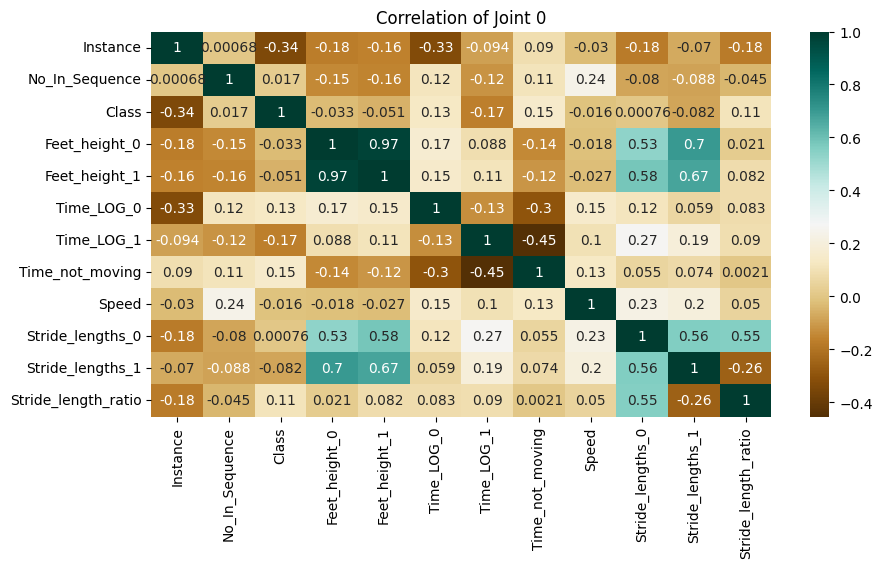

In [40]:
#dataset_master = dataset_master.drop(['Instance', 'No_In_Sequence'], axis = 1)
dataset_array = dataset_master
plot_confusion_matrix([dataset_array], "Correlation of Joint ")

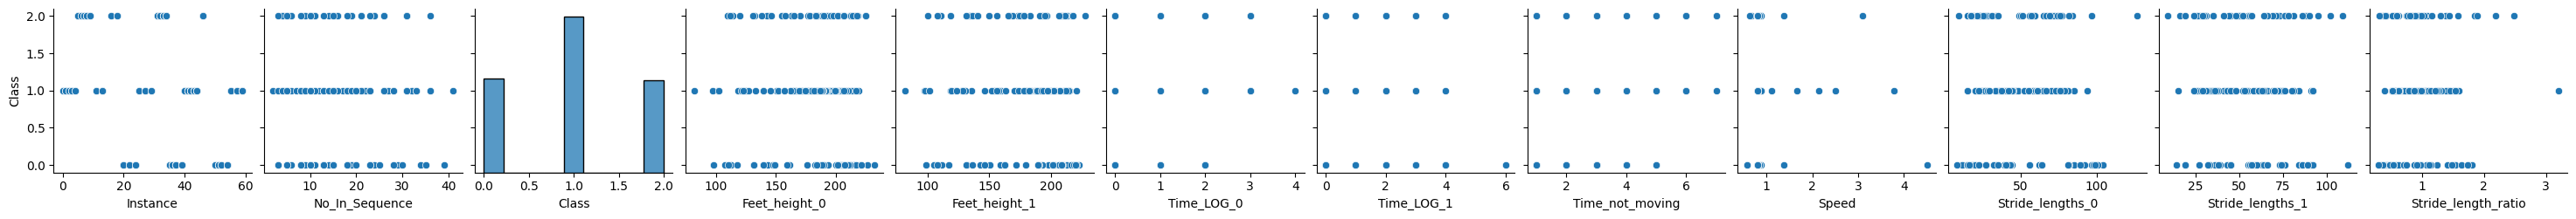

In [41]:
    sns.pairplot(data = dataset_master, x_vars=dataset_master.columns, \
            y_vars=['Class'])

In [44]:
dataset_master = pd.read_csv("./Finished_Data/hcf_dataset_pixels.csv", names=hcf_colnames, header=None)
#dataset_master = dataset_master.drop(['Stride_length_ratio', "Feet_height_0"], axis = 1)
X, y = set_data(dataset_master, [], legs = False)
SVM_classifier, y_test, y_pred = run_SVM_test(X, y)
y_test.value_counts()

#Speed is 100% wrong, same with s
#Feet height 0 is useless, maybe use a ratio?
#Time not moving not very accurate

Accuracy: 0.4

Precision: 0.16

Recall: 0.4


C:\Users\chris\.conda\envs\procenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1    18
2    15
0    12
Name: Class, dtype: int64

<AxesSubplot: xlabel='Class'>

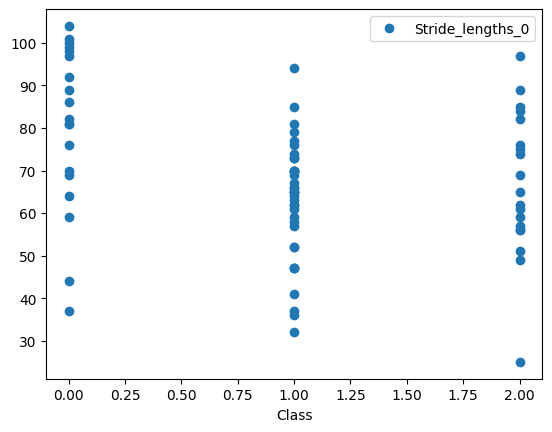

In [36]:
dataset_master = pd.read_csv("./Finished_Data/hcf_dataset_pixels.csv", names=hcf_colnames, header=None)
dataset_master.plot(x='Class', y='Stride_lengths_0', style='o')

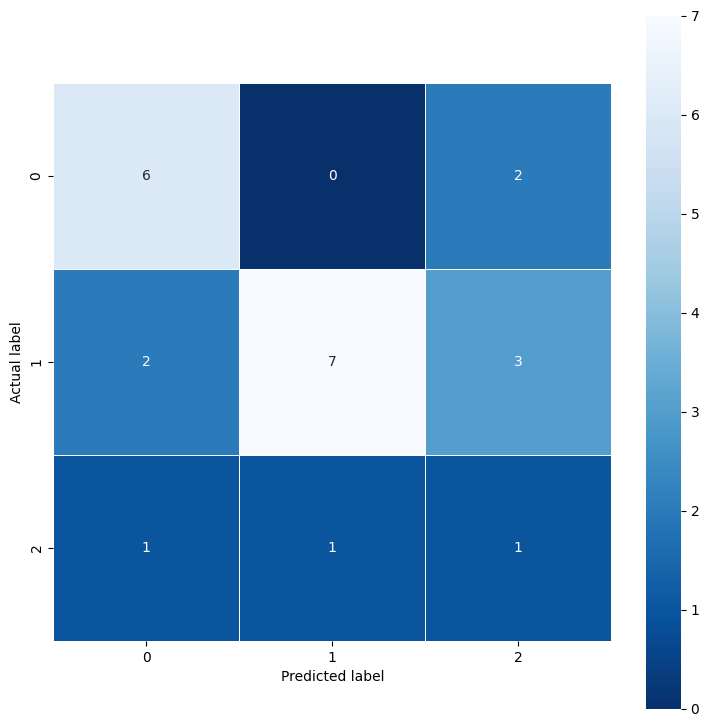

In [34]:
#log_classifier, y_test, y_pred = run_LOGREG_test(X, y)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_results(cm)

In [ ]:
#Try and normalize all values between 0-1

#PCA features

#Revise/ add features